---
title: Linux SPI 的使用
keywords: maixpy3, SPI, Linux
desc: maixpy3  SPI 的使用
---

| 更新时间 | 负责人 | 内容 | 备注 |
| --- | --- | --- | --- |
| 2022年1月4日 | Rui | 初次编写文档 | --- |
| 2022年1月8日 | Rui | 修改文档的编写方式 | 使用 Jupyter notebook 进行编写文档 |
| 2022年1月18日 | Rui | 修改文档，增加效果图 | 外设文档通过测试的平台有 MaixII-Dock，使用的是 MaixPy3 0.4.0 |

## 使用教程

在 Linux 系统中，SPI 是以设备的形式存在（/dev/spidevX.X），所使用的方式和原来的单片机方式有所不同。下面以 MaixII-Dock 为例子，来简单的简述一下如何使用 SPI。

### 准备

通过查看开发板的管脚定义图，确定自己使用的 SPI 通道序号，片选序号。


### 开始

![MaixII-Dock 管脚图](./../asserts/M2Dock_pin.jpg)

以 MaixII-Dock 为例。查看 MaixII-Dock 管脚图，只引出了一个 SPI 通道，使用的是 SPI-1，片选0。使用代码为

In [1]:
from maix import spi
spi = spi.SpiDev()
spi.open(1, 0)
spi.bits_per_word = 8
spi.max_speed_hz = 1
spi.mode = 0b11
import time
for i in range(3):
  time.sleep(0.1)
  to_send = [0x01, 0x02, 0x01]
  print(spi.xfer2(to_send, 800000))

[ rpyc-kernel ]( running at Mon Jan 17 17:13:45 2022 )
[1, 2, 1]
[1, 2, 1]
[1, 2, 1]


通过短接 SPI 的 MOSI 和 MISO 进行通讯测试

![](./../asserts/SPI.jpg)

这里所使用的是标准 Python 中的 spidev 库，更多的使用方法可以查看 [Python spidev](https://www.baidu.com/s?ie=utf-8&wd=Python%20spidev)


## 使用 SPI 驱动 WS2812B 灯珠


![spi_ws2812](./../asserts/spi_ws2812.gif)


[【STM32】WS2812介绍、使用SPI+DMA发送数据](https://www.cnblogs.com/PureHeart/p/11349495.html)

需要注意的是 SPI 的数据如果开头和结尾不修改一下会被默认高电平，所以要前后要使用 `0b1000000` (或 `0b100` 均可) 让 SPI MODE 3 的在通信时的起始数据为低电平，这样才不会出现首位为 绿灯 或尾部为 蓝灯 的情况，它的颜色顺序是 G R B 并且颜色数据位应在 0 ~ 127 之间。

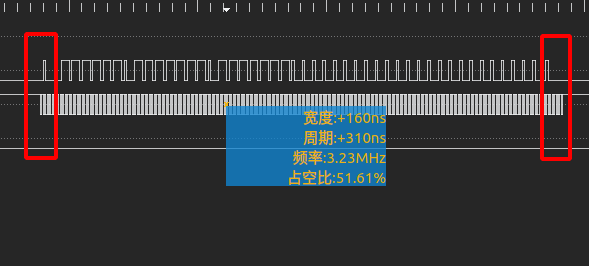


In [1]:
import time

def write2812_numpy4(spi,data):
    import numpy
    #print spi
    d=numpy.array(data).ravel()
    tx=numpy.zeros(len(d)*4, dtype=numpy.uint8)
    for ibit in range(4):
        #print ibit
        #print ((d>>(2*ibit))&1), ((d>>(2*ibit+1))&1)
        tx[3-ibit::4]=((d>>(2*ibit+1))&1)*0x60 + ((d>>(2*ibit+0))&1)*0x06 +  0x88
    spi.xfer(tx.tolist()*2, int(4/1.25e-6)) #works, on Zero (initially didn't?)
    
def write2812_pylist4(spi, data):
    tx=[]
    for rgb in data:
        for byte in rgb: 
            for ibit in range(3,-1,-1):
                #print ibit, byte, ((byte>>(2*ibit+1))&1), ((byte>>(2*ibit+0))&1), [hex(v) for v in tx]
                tx.append(((byte>>(2*ibit+1))&1)*0x60 +
                          ((byte>>(2*ibit+0))&1)*0x06 +
                          0x88)
    print([hex(v) for v in tx])
    tx[0] = 0b1000000 # spi need clear head high level
    tx.append(0b1000000) # spi need clear end high level
    spi.xfer(tx, int(4/1.05e-6))

write2812=write2812_pylist4

from maix import spi
spi = spi.SpiDev()
spi.open(1, 0)
spi.mode = 3
spi.bits_per_word = 8
spi.max_speed_hz = 20000000

write2812(spi, [[127,127,127], [0,0,0]])
time.sleep(0.5)
write2812(spi, [[0,0,0], [0,0,0]])
time.sleep(0.5)

write2812(spi, [[0,0,0], [127,127,127]])
time.sleep(0.5)
write2812(spi, [[0,0,0], [0,0,0]])
time.sleep(0.5)

# # red
write2812(spi, [[0,127,0], [0,127,0]])
time.sleep(0.2)
write2812(spi, [[0,0,0], [0,0,0]])
time.sleep(0.2)

# # green
write2812(spi, [[127,0,0], [127,0,0]])
time.sleep(0.2)
write2812(spi, [[0,0,0], [0,0,0]])
time.sleep(0.2)

# blue
write2812(spi, [[0,0,127], [0,0,127]])
time.sleep(0.2)
write2812(spi, [[0,0,0], [0,0,0]])
time.sleep(0.2)

write2812(spi, [[10,10,10], [10,10,10]])
time.sleep(0.2)
write2812(spi, [[0,0,0], [0,0,0]])
time.sleep(0.2)


[dls][ rpyc-kernel ]( running at Tue Dec 20 11:22:22 2022 )
['0x8e', '0xee', '0xee', '0xee', '0x8e', '0xee', '0xee', '0xee', '0x8e', '0xee', '0xee', '0xee', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88']
['0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88']
['0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x8e', '0xee', '0xee', '0xee', '0x8e', '0xee', '0xee', '0xee', '0x8e', '0xee', '0xee', '0xee']
['0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88']
['0x88', '0x88', '0x88', '0x88', '0x8e', '0xee', '0xee', '0xee', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x88', '0x8e', '0xee', '0xee', '0xee', '0x88',


## 了解更多

SPI 通信协议的[原理](https://zhuanlan.zhihu.com/p/139903418)

关于 MaixII-Dock SPI 更多详情可以查看大佬鼠的博文[为 AW V831 配置 spidev 模块，使用 py-spidev 进行用户层的 SPI 通信。 ](https://www.cnblogs.com/juwan/p/14341406.html)